In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp

import arviz as az
import numpyro

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
import numpyro.distributions as dist
from hbmep.model import Baseline

class MixedEffects(Baseline):
    LINK = "MixedEffects"

    def __init__(self, config: Config):
        super(MixedEffects, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_baseline = 1
        n_feature0 = 2
        # n_delta = 1

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
            global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

            global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(1))
            global_sigma_l_baseline = numpyro.sample("global_sigma_l_baseline", dist.HalfNormal(100))
            global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(5))

            global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
            global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

            global_sigma_p_baseline = numpyro.sample("global_sigma_p_baseline", dist.HalfNormal(100))

            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample("mu_a_baseline", dist.HalfNormal(scale=5))
                sigma_a_baseline = numpyro.sample("sigma_a_baseline", dist.HalfNormal(scale=1))

                sigma_b_raw_baseline = numpyro.sample("sigma_b_raw_baseline", dist.HalfNormal(scale=1))
                sigma_b_baseline = numpyro.deterministic("sigma_b_baseline", global_sigma_b_baseline * sigma_b_raw_baseline)

                sigma_v_raw_baseline = numpyro.sample("sigma_v_raw_baseline", dist.HalfNormal(scale=1))
                sigma_v_baseline = numpyro.deterministic("sigma_v_baseline", global_sigma_v_baseline * sigma_v_raw_baseline)

                sigma_L_raw_baseline = numpyro.sample("sigma_L_raw_baseline", dist.HalfNormal(scale=1))
                sigma_L_baseline = numpyro.deterministic("sigma_L_baseline", global_sigma_L_baseline * sigma_L_raw_baseline)

                sigma_l_raw_baseline = numpyro.sample("sigma_l_raw_baseline", dist.HalfNormal(scale=1))
                sigma_l_baseline = numpyro.deterministic("sigma_l_baseline", global_sigma_l_baseline * sigma_l_raw_baseline)

                sigma_H_raw_baseline = numpyro.sample("sigma_H_raw_baseline", dist.HalfNormal(scale=1))
                sigma_H_baseline = numpyro.deterministic("sigma_H_baseline", global_sigma_H_baseline * sigma_H_raw_baseline)

                sigma_g_1_raw_baseline = numpyro.sample("sigma_g_1_raw_baseline", dist.HalfNormal(scale=1))
                sigma_g_1_baseline = numpyro.deterministic("sigma_g_1_baseline", global_sigma_g_1_baseline * sigma_g_1_raw_baseline)

                sigma_g_2_raw_baseline = numpyro.sample("sigma_g_2_raw_baseline", dist.HalfNormal(scale=1))
                sigma_g_2_baseline = numpyro.deterministic("sigma_g_2_baseline", global_sigma_g_2_baseline * sigma_g_2_raw_baseline)

                sigma_p_raw_baseline = numpyro.sample("sigma_p_raw_baseline", dist.HalfNormal(scale=1))
                sigma_p_baseline = numpyro.deterministic("sigma_p_baseline", global_sigma_p_baseline * sigma_p_raw_baseline)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw_baseline = numpyro.sample("a_raw_baseline", dist.Gamma(concentration=mu_a_baseline, rate=1))
                    a_baseline = numpyro.deterministic("a_baseline", (1 / sigma_a_baseline) * a_raw_baseline)

                    b_raw_baseline = numpyro.sample("b_raw_baseline", dist.HalfNormal(scale=1))
                    b_baseline = numpyro.deterministic("b_baseline", sigma_b_baseline * b_raw_baseline)

                    v_raw_baseline = numpyro.sample("v_raw_baseline", dist.HalfNormal(scale=1))
                    v_baseline = numpyro.deterministic("v_baseline", sigma_v_baseline * v_raw_baseline)

                    L_raw_baseline = numpyro.sample("L_raw_baseline", dist.HalfNormal(scale=1))
                    L_baseline = numpyro.deterministic("L_baseline", sigma_L_baseline * L_raw_baseline)

                    l_raw_baseline = numpyro.sample("l_raw_baseline", dist.HalfNormal(scale=1))
                    l_baseline = numpyro.deterministic("l_baseline", sigma_l_baseline * l_raw_baseline)

                    H_raw_baseline = numpyro.sample("H_raw_baseline", dist.HalfNormal(scale=1))
                    H_baseline = numpyro.deterministic("H_baseline", sigma_H_baseline * H_raw_baseline)

                    g_1_raw_baseline = numpyro.sample("g_1_raw_baseline", dist.HalfCauchy(scale=1))
                    g_1_baseline = numpyro.deterministic("g_1_baseline", sigma_g_1_baseline * g_1_raw_baseline)

                    g_2_raw_baseline = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2_baseline = numpyro.deterministic("g_2_baseline", sigma_g_2_baseline * g_2_raw_baseline)

                    p_raw_baseline = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p_baseline = numpyro.deterministic("p_baseline", sigma_p_baseline * p_raw_baseline)

        # """ Delta """
        # with numpyro.plate(site.n_response, self.n_response, dim=-1):
        #     mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(0, 100))
        #     sigma_a_delta = numpyro.sample("sigma_a_delta", dist.HalfNormal(100))

        #     with numpyro.plate("n_delta", n_delta, dim=-2):
        #         with numpyro.plate(site.n_subject, n_subject, dim=-3):
        #             a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Deterministic """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    l = numpyro.deterministic(
                        "l",
                        jnp.concatenate([l_baseline, l_baseline], axis=1)
                    )

                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    p = numpyro.deterministic(
                        "p",
                        jnp.concatenate([p_baseline, p_baseline], axis=1)
                    )

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[subject, feature0]
                    + jnp.where(
                        intensity <= a[subject, feature0],
                        0,
                        -l[subject, feature0]
                        + (
                            (H[subject, feature0] + l[subject, feature0])
                            / jnp.power(
                                1
                                + (
                                    (
                                        -1
                                        + jnp.power(
                                            (H[subject, feature0] + l[subject, feature0]) / l[subject, feature0],
                                            v[subject, feature0]
                                        )
                                    )
                                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0]))
                                ),
                                1 / v[subject, feature0]
                            )
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )



In [3]:
root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/paper/tms/MixedEffects.toml")

config = Config(toml_path=toml_path)
# config.MCMC_PARAMS["num_warmup"] = 40000
# config.MCMC_PARAMS["num_samples"] = 60000
# config.MCMC_PARAMS["thinning"] = 4

model = MixedEffects(config=config)


2023-10-16 11:50:28,912 - hbmep.config - INFO - Verifying configuration ...
2023-10-16 11:50:28,912 - hbmep.config - INFO - Success!
2023-10-16 11:50:28,933 - hbmep.model.baseline - INFO - Initialized model with MixedEffects link


In [4]:
src = "/home/vishu/data/hbmep-processed/human/tms/data_pkpk_auc.csv"
df = pd.read_csv(src)

df[model.features[0]] = 0

# subset = ["SCA01"]
# ind = df[model.subject].isin(subset)
# df = df[ind].reset_index(drop=True).copy()

df, encoder_dict = model.load(df=df)


2023-10-16 11:50:29,001 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/tms/MixedEffects
2023-10-16 11:50:29,001 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/tms/MixedEffects
2023-10-16 11:50:29,002 - hbmep.dataset.core - INFO - Processing data ...
2023-10-16 11:50:29,004 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
from numpyro.infer import NUTS

target_accept_prob = .95
max_tree_depth = 20
forward_mode_differentiation = True

sampler = NUTS(model=model._model, max_tree_depth=max_tree_depth)


In [6]:
mcmc, posterior_samples = model.run_inference(df=df, sampler=sampler)


2023-10-16 11:50:29,153 - hbmep.model.baseline - INFO - Running inference with MixedEffects ...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
prediction_df = model.make_prediction_dataset(df=df)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-10-16 11:39:58,963 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-10-16 11:39:59,745 - hbmep.utils.utils - INFO - func:predict took: 0.78 sec
2023-10-16 11:39:59,747 - hbmep.model.baseline - INFO - Rendering ...
2023-10-16 11:40:00,008 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/MixedEffects/recruitment_curves.pdf
2023-10-16 11:40:00,008 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 0.26 sec
2023-10-16 11:40:00,010 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-16 11:40:00,216 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/paper/tms/MixedEffects/posterior_predictive_check.pdf
2023-10-16 11:40:00,216 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 0.21 sec
2023-10-16 11:40:00,217 - hbmep.utils.utils - INFO - func:render_predictive_check took: 0.21 sec


In [11]:
mcmc.print_summary(prob=.95)


                                  mean       std    median      2.5%     97.5%     n_eff     r_hat
       H_raw_baseline[0,0,0]      0.74      0.50      0.61      0.09      1.76    334.83      1.01
       L_raw_baseline[0,0,0]      0.46      0.49      0.29      0.00      1.48    372.87      1.01
       a_raw_baseline[0,0,0]      7.25      4.08      6.67      0.60     14.99    260.73      1.00
       b_raw_baseline[0,0,0]      0.48      0.48      0.32      0.00      1.48    469.42      1.01
     g_1_raw_baseline[0,0,0]      0.81      1.17      0.44      0.01      2.67    418.28      1.01
              g_2_raw[0,0,0]    199.84    314.94    106.15      8.47    630.27    338.93      1.02
  global_sigma_H_baseline[0]      3.88      2.59      3.28      0.40      9.05    263.65      1.02
  global_sigma_L_baseline[0]      0.38      0.45      0.21      0.00      1.39    431.47      1.02
  global_sigma_b_baseline[0]     50.99     47.34     36.55      0.14    144.76    314.26      1.02
global_si

In [ ]:
numpyro_data = az.from_numpyro(mcmc)

""" Model evaluation """
logger.info("Evaluating model ...")


2023-10-13 16:47:36,865 - __main__ - INFO - Evaluating model ...


In [ ]:
score = az.loo(numpyro_data)
logger.info(f"ELPD LOO (Log): {score.elpd_loo:.2f}")

/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
2023-10-13 16:47:39,557 - __main__ - INFO - ELPD LOO (Log): 670.68


In [ ]:
score = az.waic(numpyro_data)
logger.info(f"ELPD WAIC (Log): {score.elpd_waic:.2f}")

/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-10-13 16:47:40,432 - __main__ - INFO - ELPD WAIC (Log): 673.82


In [ ]:
import pickle

dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)

In [ ]:
import pickle

with open(dest, "rb") as g:
    model_, mcmc_, posterior_samples_ = pickle.load(g)


In [ ]:
class Simulation(Baseline):
    LINK = "Simulation"

    def __init__(self, config: Config, n_delta, mu_a_delta, sigma_a_delta):
        super(Simulation, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.n_delta, self.mu_a_delta, self.sigma_a_delta = n_delta, mu_a_delta, sigma_a_delta

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_feature0 = 2
        n_delta = self.n_delta

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
            global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

            global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(1))
            global_sigma_l_baseline = numpyro.sample("global_sigma_l_baseline", dist.HalfNormal(100))
            global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(5))

            global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
            global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

            global_sigma_p_baseline = numpyro.sample("global_sigma_p_baseline", dist.HalfNormal(100))

            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample("mu_a_baseline", dist.HalfNormal(scale=5))
                sigma_a_baseline = numpyro.sample("sigma_a_baseline", dist.HalfNormal(scale=1))

                sigma_b_raw_baseline = numpyro.sample("sigma_b_raw_baseline", dist.HalfNormal(scale=1))
                sigma_b_baseline = numpyro.deterministic("sigma_b_baseline", global_sigma_b_baseline * sigma_b_raw_baseline)

                sigma_v_raw_baseline = numpyro.sample("sigma_v_raw_baseline", dist.HalfNormal(scale=1))
                sigma_v_baseline = numpyro.deterministic("sigma_v_baseline", global_sigma_v_baseline * sigma_v_raw_baseline)

                sigma_L_raw_baseline = numpyro.sample("sigma_L_raw_baseline", dist.HalfNormal(scale=1))
                sigma_L_baseline = numpyro.deterministic("sigma_L_baseline", global_sigma_L_baseline * sigma_L_raw_baseline)

                sigma_l_raw_baseline = numpyro.sample("sigma_l_raw_baseline", dist.HalfNormal(scale=1))
                sigma_l_baseline = numpyro.deterministic("sigma_l_baseline", global_sigma_l_baseline * sigma_l_raw_baseline)

                sigma_H_raw_baseline = numpyro.sample("sigma_H_raw_baseline", dist.HalfNormal(scale=1))
                sigma_H_baseline = numpyro.deterministic("sigma_H_baseline", global_sigma_H_baseline * sigma_H_raw_baseline)

                sigma_g_1_raw_baseline = numpyro.sample("sigma_g_1_raw_baseline", dist.HalfNormal(scale=1))
                sigma_g_1_baseline = numpyro.deterministic("sigma_g_1_baseline", global_sigma_g_1_baseline * sigma_g_1_raw_baseline)

                sigma_g_2_raw_baseline = numpyro.sample("sigma_g_2_raw_baseline", dist.HalfNormal(scale=1))
                sigma_g_2_baseline = numpyro.deterministic("sigma_g_2_baseline", global_sigma_g_2_baseline * sigma_g_2_raw_baseline)

                sigma_p_raw_baseline = numpyro.sample("sigma_p_raw_baseline", dist.HalfNormal(scale=1))
                sigma_p_baseline = numpyro.deterministic("sigma_p_baseline", global_sigma_p_baseline * sigma_p_raw_baseline)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw_baseline = numpyro.sample("a_raw_baseline", dist.Gamma(concentration=mu_a_baseline, rate=1))
                    a_baseline = numpyro.deterministic("a_baseline", (1 / sigma_a_baseline) * a_raw_baseline)

                    b_raw_baseline = numpyro.sample("b_raw_baseline", dist.HalfNormal(scale=1))
                    b_baseline = numpyro.deterministic("b_baseline", sigma_b_baseline * b_raw_baseline)

                    v_raw_baseline = numpyro.sample("v_raw_baseline", dist.HalfNormal(scale=1))
                    v_baseline = numpyro.deterministic("v_baseline", sigma_v_baseline * v_raw_baseline)

                    L_raw_baseline = numpyro.sample("L_raw_baseline", dist.HalfNormal(scale=1))
                    L_baseline = numpyro.deterministic("L_baseline", sigma_L_baseline * L_raw_baseline)

                    l_raw_baseline = numpyro.sample("l_raw_baseline", dist.HalfNormal(scale=1))
                    l_baseline = numpyro.deterministic("l_baseline", sigma_l_baseline * l_raw_baseline)

                    H_raw_baseline = numpyro.sample("H_raw_baseline", dist.HalfNormal(scale=1))
                    H_baseline = numpyro.deterministic("H_baseline", sigma_H_baseline * H_raw_baseline)

                    g_1_raw_baseline = numpyro.sample("g_1_raw_baseline", dist.HalfCauchy(scale=1))
                    g_1_baseline = numpyro.deterministic("g_1_baseline", sigma_g_1_baseline * g_1_raw_baseline)

                    g_2_raw_baseline = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2_baseline = numpyro.deterministic("g_2_baseline", sigma_g_2_baseline * g_2_raw_baseline)

                    p_raw_baseline = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p_baseline = numpyro.deterministic("p_baseline", sigma_p_baseline * p_raw_baseline)

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.deterministic("mu_a_delta", self.mu_a_delta)
                sigma_a_delta = numpyro.sample("sigma_a_delta", self.sigma_a_delta)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Deterministic """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    l = numpyro.deterministic(
                        "l",
                        jnp.concatenate([l_baseline, l_baseline], axis=1)
                    )

                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    p = numpyro.deterministic(
                        "p",
                        jnp.concatenate([p_baseline, p_baseline], axis=1)
                    )

        """ Penalty """
        penalty = (jnp.fabs(a_baseline + a_delta) - (a_baseline + a_delta))
        numpyro.factor("a_penalty", -penalty)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[subject, feature0]
                    + jnp.where(
                        intensity <= a[subject, feature0],
                        0,
                        -l[subject, feature0]
                        + (
                            (H[subject, feature0] + l[subject, feature0])
                            / jnp.power(
                                1
                                + (
                                    (
                                        -1
                                        + jnp.power(
                                            (H[subject, feature0] + l[subject, feature0]) / l[subject, feature0],
                                            v[subject, feature0]
                                        )
                                    )
                                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0]))
                                ),
                                1 / v[subject, feature0]
                            )
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )

        # with numpyro.plate(site.data, n_data):
        #     return numpyro.sample(
        #         site.obs,
        #         dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
        #         obs=response_obs
        #     )


In [ ]:
prediction_dataset = 

<Axes: ylabel='Density'>

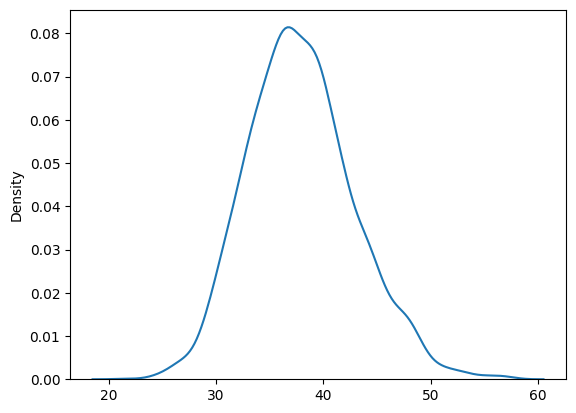

In [ ]:
import seaborn as sns

sns.kdeplot(posterior_samples["mu_a_baseline"].reshape(-1,) / posterior_samples["sigma_a_baseline"].reshape(-1,))
